# Zillow 'Zestimate' error prediction
## 1. Overview
Home value prediction is an efficient way to represent the general information for homes, which is important for both buyers and sellers to understand the housing market and monitor the values of their properties. The online real estate database company Zillow provides its own home value prediction (Zestimate) to help consumers predict home value at no cost. The 'Zestimate' estimates home values according to 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. The Zillow company keeps improving their 'Zestimate', and its current median margin of error compared to the real sale price has dropped from 20% to 5% during the last 11 years. However, even though the prediction has a relatively high accuracy in percentage (95%), due to the high total price of each property, the error in price prediction is still large enough to affect its reliability especially for buyers who need to apply for financial loan based on accurate home value.

The question is whether the 'Zestimate' can be further improved for higher accuracy and reliability. This is an interesting and important topic not only for the company but also any buyer or seller. In order to achieve this goal, it is necessary to evaluate the performance of the existing 'Zestimate' and find the weak point of the current algorithm. In this project, different machine learning techniques will be applied to build a predictive model that estimates the error between the 'Zestimate' and real sale price according to the information of each property. The predictive model can quantitatively analyze how the performance of 'Zestimate' varies under different scenarios for different properties, determines the key factors or features which induce errors due to the possible inadequate representation in the current 'Zestimate', and helps improving the design of a new algorithm for home value prediction.

**
Goals: 
<br>1. build model to predict the error, regression problem.
<br>2. find which part of the algorithm needs to be reconsidered.
**

## 2. Data preprocessing and exploratory data analysis (EDA)
The part includes the preprocessing and EDA for two portions of data, a full list of real estate properties data and the completed transactions in three counties (Los Angeles, Orange and Ventura, California) during 2016. The dataset is provided by Zillow for the Zillow prize competition held on the Kaggle platform (https://www.kaggle.com/c/zillow-prize-1). 

The first portion of the dataset provides the sale date and $\xi_{\log}$ of 90811 transactions for all houses sold within year 2016. The original dataset has already been split into training and test portions. The training data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016. The rest of data forms the test dataset. Since the dataset is provided for an online competition, the test dataset is not accessible from the Kaggle platform to avoid cheating and abuse.

The second portion of the dataset provides the basic information for 2985217 houses. For each house, this portion provides information of 58 numeric and categorical features. All the features will be treated as the input for the predictive model to estimate $\xi_{\log}$. 

The following analysis has the following steps:
<br>1. data quality check
<br>2. data preprocessing
<br>3. exploratory analysis: achieve some insights to help model development 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
from scipy.stats import norm
#color = sns.color_palette()
%matplotlib inline

### 2.1 Transaction data

Since the data is clean with only three features, property ID, prediction error, transaction date, no extra preprocessing is required. The analysis checks the characteristics of the data and predict possible relationship between different features. 

In [3]:
# get insight on the log error at different time
# exploratory analysis for the transaction data
transaction=pd.read_csv('train_2016.csv', parse_dates=["transactiondate"]);

In [4]:
transaction.shape

(90811, 3)

In [5]:
# get the size of the transaction data
(M,N)=transaction.shape
print("There are",M,"houses have been sold during 2016.")

There are 90811 houses have been sold during 2016.


In [6]:
# number of houses which has been sold for more than one time
print('There are',len(transaction['parcelid'].unique()),'unique properties have been sold during 2016,\n and there are',
     M-len(transaction['parcelid'].unique()),'houses have been sold for more than once.')
# get the sold times distribution for all houses
property_sold_times=transaction['parcelid'].value_counts()
property_sold_times.value_counts()

There are 90682 unique properties have been sold during 2016,
 and there are 129 houses have been sold for more than once.


1    90554
2      127
3        1
Name: parcelid, dtype: int64

**Insight 1. Some houses have been sold for multiple times in the dataset. These houses may be a good portion of data to show the importance of transaction date.**

In [7]:
# log error for one property that sold for three times
property_id_sold_3_times=property_sold_times[property_sold_times==3].index.tolist()
transaction[transaction['parcelid'].apply(lambda x: True if x in property_id_sold_3_times else False)]

,parcelid,logerror,transactiondate
56145,11842707,-0.0284,2016-07-14
68924,11842707,0.0573,2016-08-22
81114,11842707,0.2078,2016-09-29


In [8]:
# log error variation for properties that sold for more than 2 times
property_id_sold_2_times=property_sold_times[property_sold_times==2].index.tolist()
property_id_sold_2_times=pd.DataFrame(property_id_sold_2_times,columns=['parcelid'])
property_id_sold_2_times['1st']=pd.Series(np.zeros(127))
property_id_sold_2_times['2nd']=pd.Series(np.zeros(127))
property_id_sold_2_times['1st'].astype(float,inplace=True)
property_id_sold_2_times['2nd'].astype(float,inplace=True)
property_id_sold_2_times.set_index('parcelid',inplace=True)
for x in property_id_sold_2_times.index.tolist():
    tmp=transaction[transaction['parcelid']==x].logerror.values.tolist()
    property_id_sold_2_times['1st'].loc[x]=tmp[0]
    property_id_sold_2_times['2nd'].loc[x]=tmp[1]
property_id_sold_2_times['diff']=property_id_sold_2_times['2nd']-property_id_sold_2_times['1st']
print('The same properties that are sold at different time have different log error, which indicates time is a factor of log error and',
     'the original algorithm from Zillow has errors in representation in Time')
property_id_sold_2_times.head(10)

The same properties that are sold at different time have different log error, which indicates time is a factor of log error and the original algorithm from Zillow has errors in representation in Time


,1st,2nd,diff
parcelid,,,
11729067,-0.3798,-0.3581,0.0217
12032773,-0.0151,0.0208,0.0359
14678446,-0.0460,-0.0111,0.0349
12596069,0.0526,0.0686,0.0160
11633771,-0.0305,0.0208,0.0513
11146377,-0.0419,-0.0171,0.0248
14316410,-0.7215,-0.0651,0.6564
12584665,0.2829,0.0478,-0.2351
11863325,0.1089,0.1947,0.0858


**Insight 2. The difference in prediction error of the same house indicates the importance of the transaction date.**

In [9]:
# extract month day year data from date
transaction['sale_month']=transaction['transactiondate'].apply(lambda x: (x.to_datetime()).month)
transaction['sale_day']=transaction['transactiondate'].apply(lambda x: (x.to_datetime()).day)
transaction['sale_year']=transaction['transactiondate'].apply(lambda x: (x.to_datetime()).year)

/Users/zyaj/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2294: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)


**Number of transactions vs. transaction date**

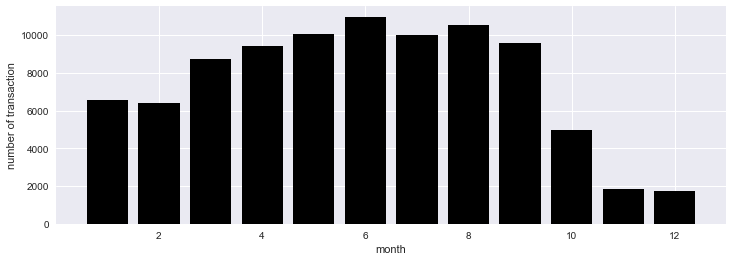

In [10]:
# distribution number of transactions 
plt.figure(figsize=(12,4))
plt.bar(range(1,13),(transaction.groupby('sale_month').count())['parcelid'],color='k')
plt.xlabel('month')
plt.ylabel('number of transaction')
#print("More transactions happens between April to September.",
#      "The number of transactions obviously decreases in the holiday season.",
#     'The reason is that a lot of transaction data between October and Decemember is used as the test data.')
#plt.savefig('num-sold-vs-month.eps',bbox_inches='tight')

**Insight 3. More transactions happens between April to September. The number of transactions obviously decreases in the holiday season. The reason is that a lot of transaction data between October and Decemember is used as the test data.**

**Scatter plot of prediction error vs. transaction date**

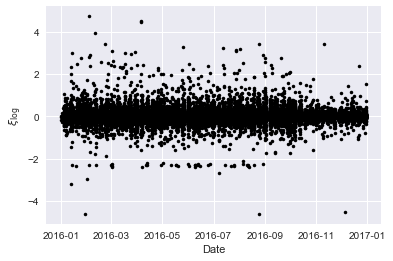

In [11]:
# plot the all log error within 2016
h=plt.plot_date(transaction['transactiondate'].apply(dates.date2num),transaction['logerror'],'k.')
plt.xlabel('Date')
plt.ylabel(r'$\xi_{\log}$')
#plt.savefig('error-vs-sold-date.eps',bbox_inches='tight')

**Prediction error vs. sale month**

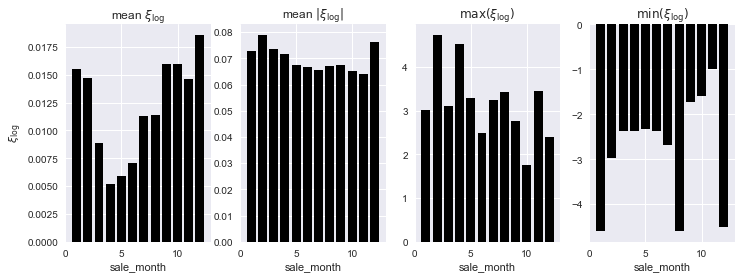

In [12]:
# plot monthly mean, absolute mean, max, and min error
transaction['sale_month'].astype(int,inplace=True)
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.bar(range(1,13),(transaction[['logerror','sale_month']].groupby('sale_month').mean()).logerror.tolist(),color='k')
plt.xlabel('sale_month')
plt.ylabel(r'$\xi_{\log}$')
plt.title(r'mean $\xi_{\log}$')
plt.subplot(1,4,2)
plt.bar(range(1,13),((transaction[['logerror','sale_month']].abs()).groupby('sale_month').mean()).logerror.tolist(),color='k')
plt.xlabel('sale_month')
plt.title(r'mean $|\xi_{\log}|$')
plt.subplot(1,4,3)
plt.bar(range(1,13),(transaction[['logerror','sale_month']].groupby('sale_month').max()).logerror,color='k')
plt.xlabel('sale_month')
plt.title(r'$\max(\xi_{\log})$')
plt.subplot(1,4,4)
plt.bar(range(1,13),(transaction[['logerror','sale_month']].groupby('sale_month').min()).logerror,color='k')
plt.xlabel('sale_month')
plt.title(r'$\min(\xi_{\log})$')
#print('Based on the mean log error, April to August has relative low error.',
#      'However, the mean log error is not the best way, since the mean absolute error does not indicate similar',
#      'pattern of variation and indicates that the log error along the whole year does not vary obviously.')
#plt.savefig('error-vs-month.eps',bbox_inches='tight')

**Insight 4. Based on the mean log error, April to August has relative low error. However, the mean log error is not the best way, since the mean absolute error does not indicate similar pattern of variation and indicates that the log error along the whole year does not vary obviously.**

**Distribution of prediction errors**

The distribution of log error is not pure normal distibution.


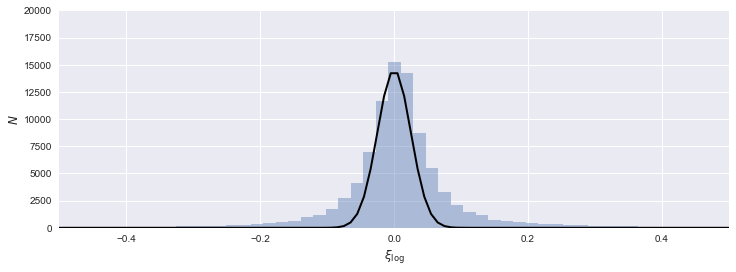

In [14]:
# plot histogram of log error
ulimit = np.percentile(transaction.logerror.values, 99)
llimit = np.percentile(transaction.logerror.values, 1)
#transaction['logerror'].loc[transaction['logerror']>ulimit] = ulimit
#transaction['logerror'].loc[transaction['logerror']<llimit] = llimit

plt.figure(figsize=(12,4))
sns.distplot(transaction.logerror.values, bins=500, kde=False)
plt.xlabel(r'$\xi_{\log}$', fontsize=12)
mu, std = norm.fit(transaction.logerror.values)
xmin,xmax=plt.xlim()
x = np.linspace(-5,5,1000)
p = norm.pdf(x, 0, 0.025)
plt.plot(x, p*(x[1]-x[0])*90811, 'k', linewidth=2)
plt.axis([-0.5,0.5,0,20000])
plt.ylabel(r'$N$', fontsize=12)
print("The distribution of log error is not pure normal distibution.")
#plt.savefig('hist-error.eps',bbox_inches='tight')

**Sale day vs. prediction error**

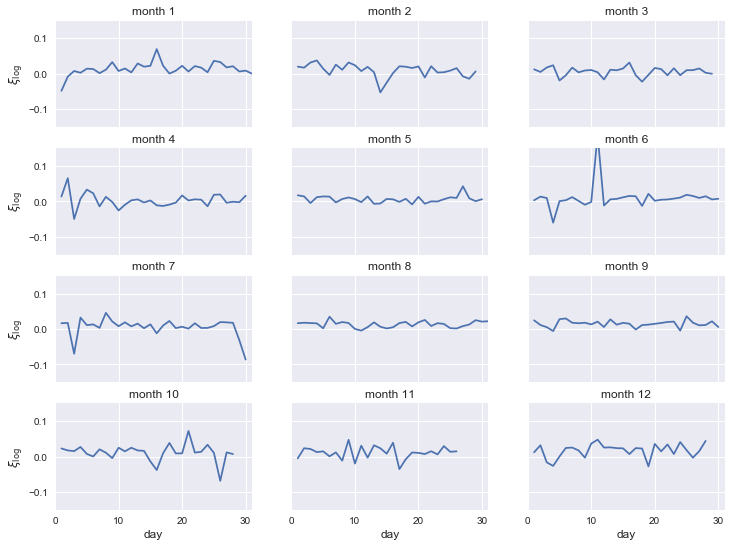

In [15]:
# plot log error distribution for each month
plt.figure(figsize=(12,9))
for i in range(1,13):
    ax=plt.subplot(4,3,i)
    tmp=transaction[transaction['sale_month']==i]
    tmp=tmp[['logerror','sale_day']].groupby('sale_day').mean()
    plt.plot(range(1,len(tmp)+1),tmp)
    plt.axis([0,31,-0.15,0.15])
    if((i!=1) & (i!=4) & (i!=7) & (i!=10)):
        ax.set_yticklabels([])
    if((i!=10) & (i!=11) & (i!=12)):
        ax.set_xticklabels([])
    plt.title('month '+str(i),fontsize=12)
    if((i==10) | (i==11) | (i==12)):
        ax.set_xlabel('day',fontsize=12)
    if((i==1) | (i==4) | (i==7) | (i==10)):
        ax.set_ylabel(r'$\xi_{\log}$',fontsize=12) 
#print("The shape of the variation of log error within each month is not obvious to indicate difference in months.",
#      "But the error is bigger in June, July and October.")
#plt.savefig('error-variation-different-month.eps',bbox_inches='tight')

**Insight 5. The shape of the variation of log error within each month is not obvious to indicate difference in months. But the error is bigger in June and July.**

### 2.2 Property data
#### 2.2.1 Data preprocessing
The original data includes 58 different features of each house. There are several steps for data preprocessing before the exploratory data analysis.
<br>A. feature classification: different features have different methods to handle.
<br>B. feature data type and value distribution
<br>C. handle missing values: drop features with high missing rate and fill missing values for other features
<br>D. new feature generation
<br>E. merge with transaction data

In [4]:
# the properties data proprocessing
properties_2016=pd.read_csv('properties_2016.csv',low_memory=False);

In [5]:
properties_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


**A. feature classification**

In [6]:
# categorize features
# based on the definition of different features
id_feature=['airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
           'buildingqualitytypeid','decktypeid','hashottuborspa','heatingorsystemtypeid',
           'pooltypeid10','pooltypeid2','pooltypeid7','propertylandusetypeid',
            'storytypeid','typeconstructiontypeid','fireplaceflag','taxdelinquencyflag',
            'taxdelinquencyyear']
cnt_feature=['bathroomcnt','bedroomcnt','calculatedbathnbr','fireplacecnt','fullbathcnt',
            'garagecarcnt','garagetotalsqft','poolcnt','roomcnt','threequarterbathnbr',
            'unitcnt','yearbuilt','numberofstories','assessmentyear']
size_feature=['basementsqft','finishedfloor1squarefeet','calculatedfinishedsquarefeet',
             'finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15',
              'finishedsquarefeet50','finishedsquarefeet6','lotsizesquarefeet',
             'poolsizesum','yardbuildingsqft17','yardbuildingsqft26','structuretaxvaluedollarcnt','taxvaluedollarcnt',
             'landtaxvaluedollarcnt','taxamount','latitude','longitude']
location_feature=['fips','propertycountylandusecode','rawcensustractandblock',
                 'regionidcity','regionidcounty','regionidneighborhood','regionidzip','censustractandblock']
str_feature=['propertyzoningdesc','propertycountylandusecode']

**B. feature data type and value distribution**

In [7]:
# data type analysis
dtype_df = properties_2016.dtypes.reset_index()
dtype_df.columns = ["Feature", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Feature
0,int64,1
1,float64,52
2,object,5


In [8]:
# feature as object 
# look into non-numeric features
dtype_df[dtype_df['Column Type']=='object']['Feature']

22               hashottuborspa
32    propertycountylandusecode
34           propertyzoningdesc
49                fireplaceflag
55           taxdelinquencyflag
Name: Feature, dtype: object

In [23]:
# values counts for propertycountylandusecode
print(properties_2016['propertycountylandusecode'].value_counts())

0100    1153896
122      522145
0101     247494
010C     225410
1111     126491
34       123249
0200     104612
010D      60503
1         60167
010E      50978
1110      38363
0300      35926
0400      32821
1129      31391
070P      23763
0104      13988
1210      10356
1118       9677
0          9501
1128       9421
73         8570
012C       8172
01DC       6407
96         5684
38         4954
71         4117
0103       3501
1200       3299
0109       3165
010V       3019
         ...   
1002          1
172G          1
01C           1
7200          1
121O          1
3414          1
02G0          1
030L          1
030B          1
9100          1
070G          1
0231          1
103           1
071P          1
020A          1
8830          1
590V          1
0141          1
2003          1
04TO          1
0305          1
0308          1
0403          1
1724          1
10G           1
0122          1
76            1
5011          1
1723          1
5900          1
Name: propertycountyland

In [24]:
# values counts for propertyzoningdesc
print(properties_2016['propertyzoningdesc'].value_counts())

LAR1          275029
LAR3           67105
LARS           54859
LBR1N          52750
LAR2           48808
LARD1.5        39895
SCUR2          30459
LARD2          30377
TORR-LO        26632
LARA           26103
LARE11         24005
LCR1YY         22460
LARE15         18655
CARS*          17021
PSR6           15032
LCR1*          14916
LKR1YY         13470
LAR4           12750
LARD3          12424
GLR1YY         12252
LAC2           11917
PRSF*          11483
LCA11*         10633
BUR1YY         10472
LCA106         10340
SCUR3          10126
BPR1*          10080
CERS5000       10075
NOR1YY          9874
ALRPD*          9324
               ...  
DOR2&HFB-R         1
BLR3               1
DOR1 *             1
GLCA*              1
LFR1100008         1
AHR1-7OOO*         1
BUR4-1*            1
RPRS*              1
LY R1YY            1
TCR172OO*          1
SLC1-R1*           1
POR1700*           1
LAR-1*             1
POC3SH             1
GLC2               1
SPR1-R3*           1
LYR1-R3*     

In [25]:
# value count for object features
print(properties_2016['hashottuborspa'].value_counts())
print(properties_2016['fireplaceflag'].value_counts())
print(properties_2016['taxdelinquencyflag'].value_counts())
#print("Features hashottuborspa,fireplaceflag and taxdelinquencyflag only have one valid values.",
#      "propertycountylandusecode and propertyzoningdesc are all strings. All the five columns will be droped.")

True    69014
Name: hashottuborspa, dtype: int64
True    5163
Name: fireplaceflag, dtype: int64
Y    56462
Name: taxdelinquencyflag, dtype: int64


In [9]:
# drop the five object columns
properties_2016.drop(dtype_df[dtype_df['Column Type']=='object']['Feature'].values.tolist(),axis=1,inplace=True)

In [10]:
properties_2016.shape

(2985217, 53)

**Insight 6. Features 'propertyzoningdesc' and 'propertycountylandusecode' have string-like with many values, thus they are difficult to transfer as numeric. Since the other three features with 'object' type have only one single value, and can be removed.**

**C. handle missing values: drop features with high missing rate and fill missing values for other features**

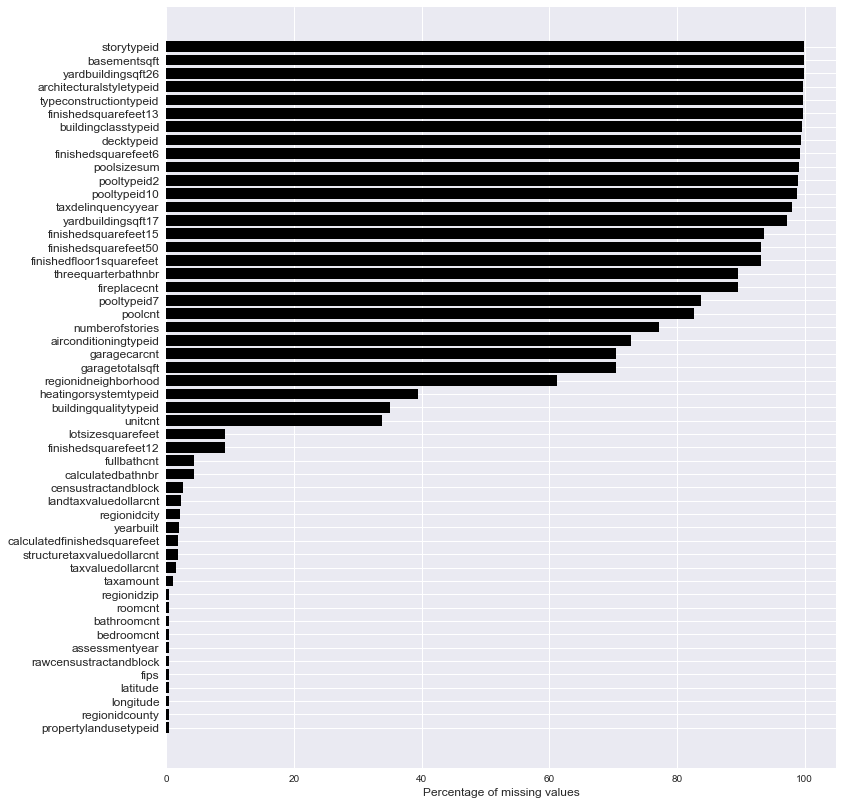

In [11]:
# check the missing percentage
missing_df = properties_2016.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,14))
rects = ax.barh(ind, missing_df.missing_count.values/2985217*100, color='k')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal',fontsize=12)
ax.set_xlabel("Percentage of missing values",fontsize=12)
#ax.set_title("Number of missing values in each column",fontsize=14)
#plt.savefig('missing-value.eps',bbox_inches='tight')

In [12]:
# missing rate of the data
missing_df['missing_rate']=missing_df['missing_count']/2985217
cutoff=0.9
print(missing_df[missing_df.missing_rate<cutoff].shape)
print('There are only',missing_df[missing_df.missing_rate<cutoff].shape[0],'features of which the percentage of missing values is less than',cutoff*100,'%.')
missing_df[(missing_df.missing_rate<cutoff)].column_name.values

(35, 3)
There are only 35 features of which the percentage of missing values is less than 90.0 %.


array(['propertylandusetypeid', 'regionidcounty', 'longitude', 'latitude',
       'fips', 'rawcensustractandblock', 'assessmentyear', 'bedroomcnt',
       'bathroomcnt', 'roomcnt', 'regionidzip', 'taxamount',
       'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
       'calculatedfinishedsquarefeet', 'yearbuilt', 'regionidcity',
       'landtaxvaluedollarcnt', 'censustractandblock', 'calculatedbathnbr',
       'fullbathcnt', 'finishedsquarefeet12', 'lotsizesquarefeet',
       'unitcnt', 'buildingqualitytypeid', 'heatingorsystemtypeid',
       'regionidneighborhood', 'garagetotalsqft', 'garagecarcnt',
       'airconditioningtypeid', 'numberofstories', 'poolcnt',
       'pooltypeid7', 'fireplacecnt', 'threequarterbathnbr'], dtype=object)

In [13]:
# drop feature missing rate>0.9
properties_2016.drop(missing_df[(missing_df.missing_rate>=cutoff)].column_name.values.tolist(),
                    axis=1,inplace=True)

In [14]:
# fill missing values
# for id_feature, fill the missing values with most frequent value
# for cnt_feature, fill the missing values with median value
# for size_feature, fill the missing values with mean values
# for location_feature, fill the missing values with the nearest values
# categorize the left feature
feature_left=properties_2016.columns.tolist()
id_feature_left=list()
cnt_feature_left=list()
size_feature_left=list()
location_feature_left=list()
for x in feature_left:
    if x in id_feature:
        id_feature_left.append(x)
    elif x in cnt_feature:
        cnt_feature_left.append(x)
    elif x in size_feature:
        size_feature_left.append(x)
    elif x in location_feature:
        location_feature_left.append(x)

# fill missing values
# for id_feature, fill the missing values with most frequent value
# for cnt_feature, fill the missing values with median value
# for size_feature, fill the missing values with mean values
# for location_feature, fill the missing values with the most frequent values
fill_missing_value=dict()
# for id_feature
for x in id_feature_left:
    fill_missing_value[x]=0#properties_2016[x].value_counts().index.tolist()[0]
# for cnt_feature
for x in cnt_feature_left:
    fill_missing_value[x]=properties_2016[x].median()
# for size_feature
for x in size_feature_left:
    fill_missing_value[x]=properties_2016[x].mean()
# for size_feature
for x in location_feature_left:
    fill_missing_value[x]=0#properties_2016[x].value_counts().index.tolist()[0]
for x in fill_missing_value:
    properties_2016[x].fillna(fill_missing_value[x],inplace=True)

In [32]:
# for location_feature
# regionidcounty and fips is the same to represent the county keep fips
# censustractandblock is drop as to be the same as rawcensustractandblock.
# regionidneighborhood >60% missing rate is droped
#properties_2016.drop(['regionidcounty','regionidneighborhood','censustractandblock'],axis=1,inplace=True)
# the maximum missing rate for the left location feature is 2% maximum. drop the rows with
# missing values
#properties_2016.dropna(axis=0,how='any',inplace=True)
#properties_2016.fillna(0,inplace=True)

In [33]:
# divide 1000000 for longitude and latitude
#properties_2016['longitude']=properties_2016['longitude']/1000000;
#properties_2016['latitude']=properties_2016['latitude']/1000000;

**D. new feature generation**

In [34]:
# add new features
# 1. tax per living area = tax amount/calculatedfinishedsquarefeet
# 2. tax per living area2 =tax amount/finishedsquarefeet12
# 3. tax per lot size=tax amount/lotsizesquarefeet
properties_2016['tax_per_liv_area']=properties_2016['taxamount']/properties_2016['calculatedfinishedsquarefeet'];
properties_2016['tax_per_liv_area2']=properties_2016['taxamount']/properties_2016['finishedsquarefeet12'];
properties_2016['tax_per_lot_size']=properties_2016['taxamount']/properties_2016['lotsizesquarefeet'];

**E. merge with transaction data**

In [35]:
# achieve data with transaction information
# only care about the error prediction in month scale
transaction.drop(['transactiondate','sale_year','sale_day'],axis=1,inplace=True)
train_df=transaction.merge(properties_2016,on='parcelid',how='left')
train_df.head(5)

,parcelid,logerror,sale_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,tax_per_liv_area,tax_per_liv_area2,tax_per_lot_size
0,11016594,0.0276,1,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,...,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,3.999929,3.999929,0.894777
1,14366692,-0.1684,1,0.0,3.5,4.0,0.0,3.5,2263.0,2263.0,...,1.0,346458.0,585529.0,2015.0,239071.0,10153.02,0.000000e+00,4.486531,4.486531,2.786994
2,12098116,-0.0040,1,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,...,1.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,5.180189,5.180189,1.005382
3,12643413,0.0218,1,1.0,2.0,2.0,4.0,2.0,839.0,839.0,...,1.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,3.633778,3.633778,0.043025
4,14432541,-0.0050,1,0.0,2.5,4.0,0.0,2.5,2283.0,2283.0,...,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,2.404275,2.404275,0.914827


In [36]:
# drop missing value which indicates these properties have no complete location information
train_df.dropna(axis=0,how='any',inplace=True)
print((len(transaction)-len(train_df))/len(transaction)*100,'% data has been removed due to the missing',
     'location information.')

0.0 % data has been removed due to the missing location information.


In [37]:
# assessmentyear only has one value, so it will be dropped
#print(properties_2016['assessmentyear'].value_counts())
#train_df.drop('assessmentyear',axis=1,inplace=True)

In [38]:
# set parcel id as index
train_df.set_index('parcelid',inplace=True)

In [39]:
# check the data type
train_df.dtypes

logerror                        float64
sale_month                        int64
airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
pooltypeid7                     float64
propertylandusetypeid           float64
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidneighborhood            float64


In [40]:
# finish data preprocessing
# check the condition of data
train_df.head(5)

,logerror,sale_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,tax_per_liv_area,tax_per_liv_area2,tax_per_lot_size
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,...,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,3.999929,3.999929,0.894777
14366692,-0.1684,1,0.0,3.5,4.0,0.0,3.5,2263.0,2263.0,6059.0,...,1.0,346458.0,585529.0,2015.0,239071.0,10153.02,0.000000e+00,4.486531,4.486531,2.786994
12098116,-0.0040,1,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,...,1.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,5.180189,5.180189,1.005382
12643413,0.0218,1,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,...,1.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,3.633778,3.633778,0.043025
14432541,-0.0050,1,0.0,2.5,4.0,0.0,2.5,2283.0,2283.0,6059.0,...,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,2.404275,2.404275,0.914827


#### 2.2.2 Exploratory data analysis
All the data preprocessing has been finished. A complete exploratory data analysis has been conducted.

**A. Location vs. prediction error**

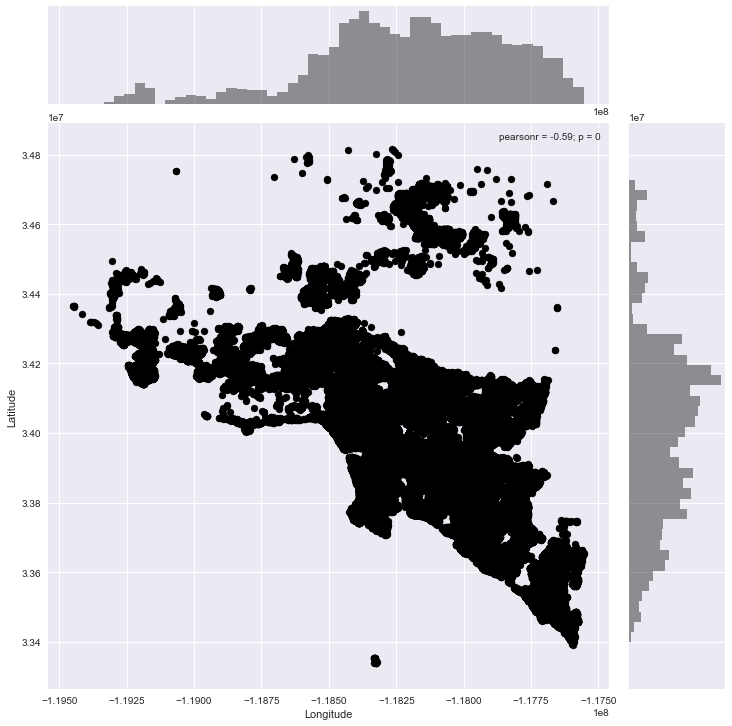

In [35]:
# exploratory analysis
# location distribution
plt.figure(figsize=(12,12))
fig=sns.jointplot(x=train_df.longitude.values, y=train_df.latitude.values, size=10,color='k')
fig.set_axis_labels('Longitude','Latitude')
#plt.colorbar(orientation="vertical",fraction=0.07)
plt.show()
plt.savefig('number-distribution-long-lat.eps',bbox_inches='tight')

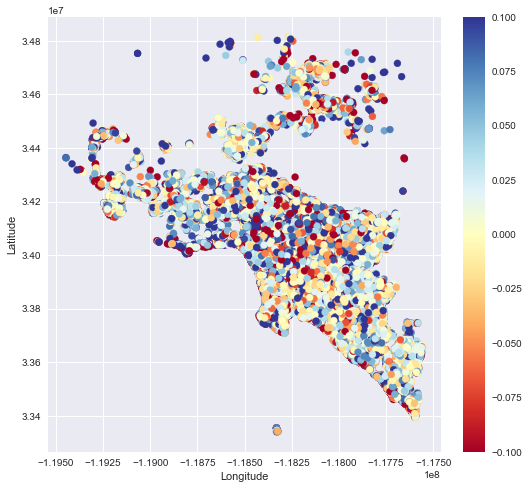

In [36]:
# location distribution vs log error
plt.figure(figsize=(8,8))
plt.scatter(train_df.longitude.values,
            train_df.latitude.values, c=train_df.logerror.values,cmap='RdYlBu')
plt.clim([-0.1,0.1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(fraction=0.07)
plt.savefig('error-long-lat.eps',bbox_inches='tight')

There is no obvious relationship between long/lat and log error.


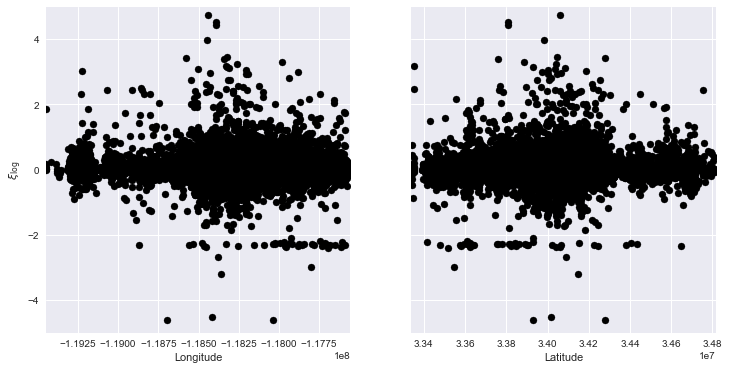

In [37]:
# plot latitude and longitude vs. log error
plt.figure(figsize=(12,6))
ax=plt.subplot(1,2,1)
plt.scatter(train_df['longitude'],train_df['logerror'],c='k')
plt.axis([train_df['longitude'].min()-0.3,train_df['longitude'].max()+0.3,-5,5])
plt.ylabel(r'$\xi_{\log}$')
plt.xlabel('Longitude')
ax=plt.subplot(1,2,2)
plt.xlabel('Latitude')
plt.scatter(train_df['latitude'],train_df['logerror'],c='k')
ax.set_yticklabels([])
plt.axis([train_df['latitude'].min()-0.3,train_df['latitude'].max()+0.3,-5,5])
print('There is no obvious relationship between long/lat and log error.')
plt.savefig('error-long-lat-scatter.eps',bbox_inches='tight')

**Insight 7. There is no obvious relationship/pattern between location (lat/long) and prediction error. This is reasonable since only the lat/long cannot clearly distinguish the advantage and disadvantage of the location of each house. However, no more relevant features are provided. This indicates that more information on the characteristics of location (like rating of school, rating of local community and etc.) is required and will benefit the prediction.**

**B. Yearbuilt vs. prediction error**

More sold properties are built during 1950-1990


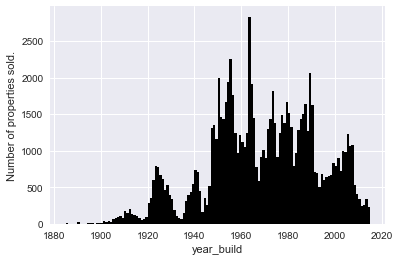

In [38]:
# the properties sold distribution in year
a=plt.hist(train_df['yearbuilt'],bins=130,normed=0,color='k')
plt.xlabel('year_build')
plt.ylabel('Number of properties sold.')
print('More sold properties are built during 1950-1990')
plt.savefig('number-sold-yearbuild.eps',bbox_inches='tight')

In [42]:
# add abs_logerror
train_df['abs_logerror']=train_df['logerror'].abs()

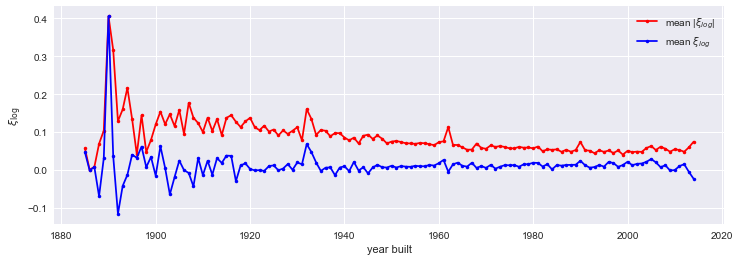

In [43]:
# relationship between log error and absolute log error 
plt.figure(figsize=(12,4))
plt.plot(range(1885,2015),train_df[['abs_logerror','yearbuilt']].groupby('yearbuilt').mean(),
         'r.-')
plt.plot(range(1885,2015),train_df[['logerror','yearbuilt']].groupby('yearbuilt').mean(),
         'b.-')
plt.xlabel('year built')
plt.ylabel(r'$\xi_{\log}$')
plt.legend([r'mean |$\xi_{log}$|',r'mean $\xi_{log}$'])
#print('The Zestimate predicts between for recent years.  Compared to the mean log error,',
#     'the mean log error shows more obvious relationship with year built.')
#plt.savefig('total-error-yearbuilt.eps',bbox_inches='tight')

**Insight 8. The Zestimate predicts between for recent years.  Compared to the mean log error, the amplitude of mean log error shows more obvious relationship with year built.**

In [44]:
# the number of the properties sold in 2016 at different counties
# 037 las vegas 059 orange 111 ventura
train_df['fips'].value_counts()

6037.0    58574
6059.0    24505
6111.0     7196
0.0         536
Name: fips, dtype: int64

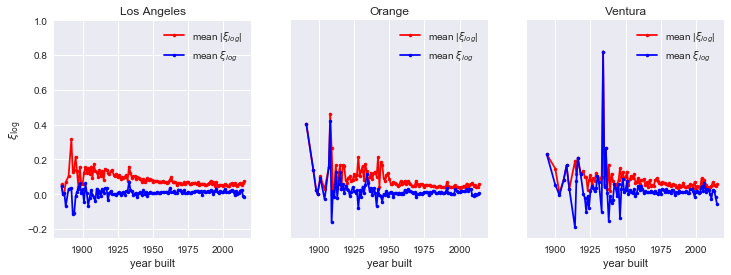

In [45]:
# check the relationship between log error and absolute log error at three counties
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
tmp=train_df[train_df['fips']==6037]
tmp1=tmp[['abs_logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'r.-')
tmp1=tmp[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'b.-')
plt.xlabel('year built')
plt.ylabel(r'$\xi_{\log}$')
plt.ylim([-0.25,1])
plt.xlim([1880,2020])
plt.title('Los Angeles')
plt.legend([r'mean |$\xi_{log}$|',r'mean $\xi_{log}$'])
plt.subplot(1,3,2)
plt.yticks([])
tmp=train_df[train_df['fips']==6059]
tmp1=tmp[['abs_logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'r.-')
tmp1=tmp[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'b.-')
plt.xlabel('year built')
plt.ylim([-0.25,1])
plt.xlim([1880,2020])
plt.title('Orange')
plt.legend([r'mean |$\xi_{log}$|',r'mean $\xi_{log}$'])
plt.subplot(1,3,3)
tmp=train_df[train_df['fips']==6111]
tmp1=tmp[['abs_logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'r.-')
plt.yticks([])
tmp1=tmp[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'b.-')
plt.xlabel('year built')
plt.ylim([-0.25,1])
plt.xlim([1880,2020])
plt.title('Ventura')
plt.legend([r'mean |$\xi_{log}$|',r'mean $\xi_{log}$'])
#print("The trend is similar among three counties for properties built year 1950. For properties built before",
#     "1950, the log error all increases, but the increase is higher for Orange and Ventura. For the total mean",
#      "log error, Zestimate has overpredicted the price for all three locations.")
#plt.savefig('diff-location-error-yearbuild.eps',bbox_inches='tight')

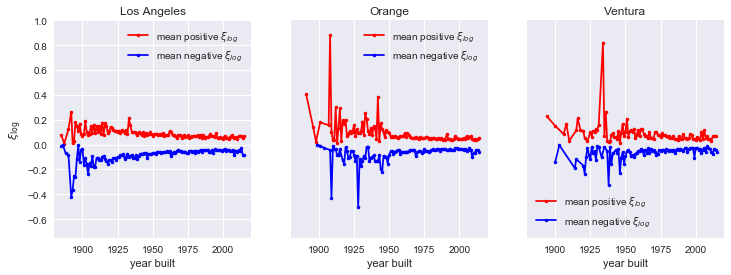

In [43]:
# check the relationship between positive and negative log error at three counties
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
tmp=train_df[train_df['fips']==6037]
tmp1=(tmp[tmp['logerror']>0])[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'r.-')
tmp1=(tmp[tmp['logerror']<=0])[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'b.-')
plt.xlabel('year built')
plt.ylabel(r'$\xi_{\log}$')
plt.ylim([-0.75,1])
plt.xlim([1880,2020])
plt.title('Los Angeles')
plt.legend([r'mean positive $\xi_{log}$',r'mean negative $\xi_{log}$'])
plt.subplot(1,3,2)
plt.yticks([])
tmp=train_df[train_df['fips']==6059]
tmp1=(tmp[tmp['logerror']>0])[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'r.-')
tmp1=(tmp[tmp['logerror']<=0])[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'b.-')
plt.xlabel('year built')
plt.ylim([-0.75,1])
plt.xlim([1880,2020])
plt.title('Orange')
plt.legend([r'mean positive $\xi_{log}$',r'mean negative $\xi_{log}$'])
plt.subplot(1,3,3)
plt.yticks([])
tmp=train_df[train_df['fips']==6111]
tmp1=(tmp[tmp['logerror']>0])[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'r.-')
tmp1=(tmp[tmp['logerror']<=0])[['logerror','yearbuilt']].groupby('yearbuilt').mean()
plt.plot(tmp1.index.tolist(),tmp1,'b.-')
plt.xlabel('year built')
plt.ylim([-0.75,1])
plt.xlim([1880,2020])
plt.title('Ventura')
plt.legend([r'mean positive $\xi_{log}$',r'mean negative $\xi_{log}$'])

**Insight 9. The trend is similar among three counties for properties with built year > 1950. For properties built before 1950, the log error all increases, but the increase is higher for Orange and Ventura. For the total mean log error, Zestimate has overpredicted the price for all three locations.**

In [44]:
# normalize
features=train_df.columns.tolist()
for x in features: #-set(dummy_feature)
    feature_max=train_df[x].max()
    feature_min=train_df[x].min()
    if(feature_max==feature_min):
        print(x,'max==min, cannot normalize, max=',feature_max)
        print('This feature only has one value, so will be dropped.')
        train_df.drop(x,axis=1,inplace=True)
    else:
        train_df[x]=(train_df[x]-feature_min)/(feature_max-feature_min)

poolcnt max==min, cannot normalize, max= 1.0
This feature only has one value, so will be dropped.
assessmentyear max==min, cannot normalize, max= 2015.0
This feature only has one value, so will be dropped.


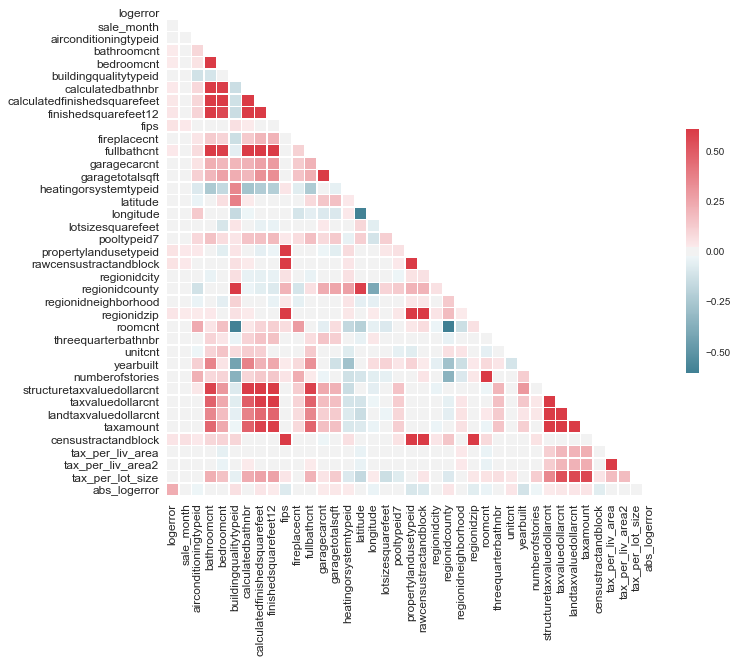

In [45]:
# correlation
plt.figure(figsize=(12,12))
sns.set(style="white")

# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Correlation coefficient of all variables in Train data')
plt.savefig('corr-train-data.eps',bbox_inches='tight')

In [46]:
corr.head(5)

,logerror,sale_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,tax_per_liv_area,tax_per_liv_area2,tax_per_lot_size,abs_logerror
logerror,1.000000,0.008033,0.006518,0.028513,0.025156,-0.000894,0.029537,0.037448,0.038510,0.051241,...,0.007587,0.021809,0.006664,-0.002747,-0.006214,0.047209,-0.013144,-0.012702,-0.019380,0.224626
sale_month,0.008033,1.000000,0.002656,0.004450,0.011147,0.014959,-0.002859,-0.005208,-0.004371,0.030853,...,0.000234,-0.004305,-0.005883,-0.007294,-0.014077,0.059491,-0.010402,-0.010786,-0.011453,-0.018746
airconditioningtypeid,0.006518,0.002656,1.000000,0.087664,0.050203,-0.121052,0.084423,0.087875,0.097020,0.023146,...,0.218279,0.037246,0.022538,0.011301,0.008575,0.029277,-0.015300,-0.015556,0.021201,-0.027648
bathroomcnt,0.028513,0.004450,0.087664,1.000000,0.646016,-0.108858,0.974326,0.756642,0.731530,0.021775,...,0.084157,0.581302,0.476358,0.353827,0.461927,0.086871,0.012791,0.023257,0.220938,-0.008062
bedroomcnt,0.025156,0.011147,0.050203,0.646016,1.000000,0.004954,0.600078,0.614864,0.560500,0.003161,...,0.095379,0.302018,0.241336,0.173213,0.239112,0.099323,-0.049189,-0.035955,0.158932,0.001039


The correlation coefficients indicate the possible important factors to predict log error.


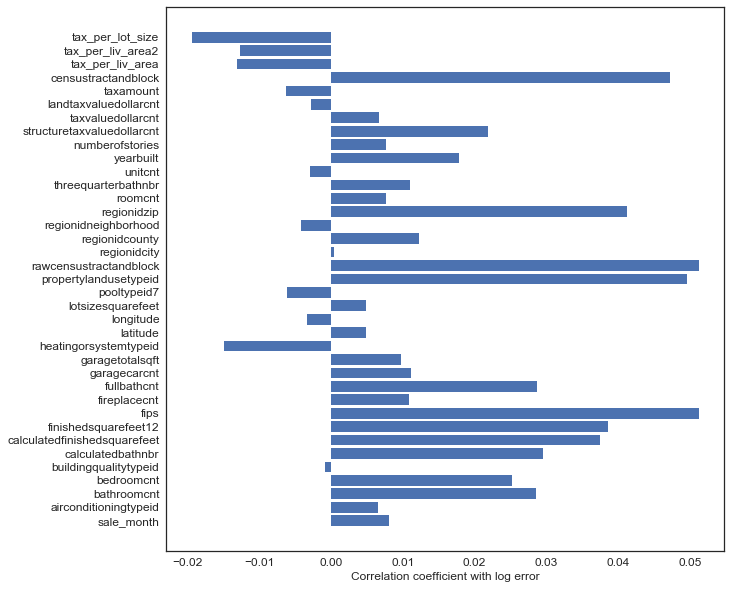

In [157]:
# correlation coefficient with log error of different features
ax=plt.figure(figsize=(10,10))
plt.barh(range(1,len(corr)-1),(corr['logerror'].values.tolist())[1:len(corr)-1])
plt.yticks(range(1,len(corr)-1), (corr.index.tolist())[1:len(corr)-1],fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Correlation coefficient with log error',fontsize=12)
#plt.title('Correlation coefficient with log error of different features',fontsize=16)
print('The correlation coefficients indicate the possible important factors to predict log error.')
plt.savefig('corr-features-vs-error.eps',bbox_inches='tight')

**Insight 10. The highest correlation coefficients is only 0.05 which indicates the relationship between prediction error and a single feature is not strong. The features with highest correlation (like fips, regionidzip, landuseid) are mostly related to location and land. But the impact from long/lat is small. Tax related features are another important type of features for prediction error.**

In [90]:
#  7+12+3+14+15
#dummy_feature=['airconditioningtypeid','buildingqualitytypeid','fips','heatingorsystemtypeid',
#              'propertylandusetypeid']

In [91]:
# add dummy variables
#for x in dummy_feature:
#    if x in features:
#        a=pd.get_dummies(properties_2016[x])
#        print(x,'is transfer to dummy vector')
#        a.columns=[x+'_'+str(n) for n in a.columns.tolist()]
#        properties_2016=pd.concat([properties_2016,a], axis=1)
#print("new properties shape:",properties_2016.shape)

In [92]:
# drop dummy vector
#properties_2016.drop(dummy_feature,axis=1,inplace=True)

## 3. Regression model development for prediction error
### 3.1 Build training and test data

In [93]:
features=properties_2016.columns.tolist()
features.remove('parcelid')
for x in features:
    feature_max=properties_2016[x].max()
    feature_min=properties_2016[x].min()
    if(feature_max==feature_min):
        print(x,'max==min, cannot normalize, max=',feature_max)
        print('This feature only has one value, so will be dropped.')
        properties_2016.drop(x,axis=1,inplace=True)
    else:
        properties_2016[x]=(properties_2016[x]-feature_min)/(feature_max-feature_min)

poolcnt max==min, cannot normalize, max= 1.0
This feature only has one value, so will be dropped.


In [98]:
# generate new train_df
train_df=transaction.merge(properties_2016,on='parcelid',how='left')
train_df.set_index('parcelid',inplace=True)

In [104]:
# get X_train y_train
X_train=train_df.iloc[:,1:]
#X_train.set_index('parcelid',inplace=True)
y_train=train_df['logerror']
print('X_train:',X_train.shape)

X_train: (90811, 38)


In [101]:
train_df.head()

,logerror,sale_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,tax_per_liv_area,tax_per_liv_area2,tax_per_lot_size
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1,0.076923,0.100,0.15,0.333333,0.052632,0.001767,0.005797,0.987891,...,0.000,0.000488,0.001274,0.9375,0.002631,0.001947,1.249841e-01,0.000336,0.000336,0.005904
14366692,-0.1684,1,0.000000,0.175,0.20,0.000000,0.131579,0.002375,0.007791,0.991491,...,0.000,0.001378,0.002071,0.9375,0.002649,0.002935,2.070264e-15,0.000377,0.000377,0.018390
12098116,-0.0040,1,0.076923,0.150,0.10,0.333333,0.105263,0.002326,0.007632,0.987891,...,0.000,0.000247,0.000424,0.9375,0.000642,0.003320,1.249915e-01,0.000435,0.000435,0.006634
12643413,0.0218,1,0.076923,0.100,0.10,0.333333,0.052632,0.000880,0.002886,0.987891,...,0.000,0.000682,0.000866,0.9375,0.000813,0.000881,1.249880e-01,0.000305,0.000305,0.000284
14432541,-0.0050,1,0.000000,0.125,0.20,0.000000,0.078947,0.002396,0.007860,0.991491,...,0.025,0.000674,0.001537,0.9375,0.002936,0.001587,1.254382e-01,0.000202,0.000202,0.006036


In [102]:
X_train.columns.tolist()

['sale_month',
 'airconditioningtypeid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'pooltypeid7',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yearbuilt',
 'numberofstories',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'tax_per_liv_area',
 'tax_per_liv_area2',
 'tax_per_lot_size']

In [103]:
# generate X_test
# load sample submission for output
sample = pd.read_csv('sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(properties_2016, on='parcelid', how='left')
# still need the sale month as input
train_feature=properties_2016.columns.tolist()
X_test=df_test[train_feature]
X_test.set_index('parcelid',inplace=True)
# predict with linear regress
X_test['sale_month']=10/12
X_test=X_test[X_train.columns.tolist()]
X_test.head(5)

/Users/zyaj/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sale_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,tax_per_liv_area,tax_per_liv_area2,tax_per_lot_size
parcelid,,,,,,,,,,,,,,,,,,,,,
10754147,0.833333,0.0,0.0,0.0,0.000000,0.052632,0.001917,0.006058,0.987891,0.0,...,0.0,0.000679,2.828994e-08,0.9375,8.864637e-08,0.001554,2.070264e-15,0.000247,0.000256,0.000414
10759547,0.833333,0.0,0.0,0.0,0.000000,0.052632,0.001917,0.006058,0.987891,0.0,...,0.0,0.000679,9.729973e-05,0.9375,3.048881e-04,0.001554,2.070264e-15,0.000247,0.000256,0.008690
10843547,0.833333,0.0,0.0,0.0,0.000000,0.052632,0.076661,0.006058,0.987891,0.0,...,0.0,0.002588,4.998076e-03,0.9375,8.450548e-03,0.006013,2.070264e-15,0.000024,0.000992,0.002176
10859147,0.833333,0.0,0.0,0.0,0.583333,0.052632,0.005319,0.006058,0.987891,0.0,...,0.0,0.002272,4.090843e-03,0.9375,6.487662e-03,0.004208,2.070264e-15,0.000241,0.000694,0.012772
10879947,0.833333,0.0,0.0,0.0,0.000000,0.052632,0.001863,0.006058,0.987891,0.0,...,0.0,0.000771,1.532926e-03,0.9375,2.656000e-03,0.001655,2.070264e-15,0.000271,0.000273,0.004438


In [105]:
# save train and X_test
train_df.to_csv('train_df_normal.csv')
print('finish save train data')
X_test.to_csv('X_test.csv')
print('finish save X_test')

finish save train data
finish save X_test


### 3.2 Model implementation and refinement
Since the $\xi_{\log}$ prediction is a regression problem, the solution basically includes two steps which are data preprocessing and the optimization of regression model. In this project, six different regression models will be applied to predict $\xi_{\log}$,  The five regression models include linear regression, $k$-nearest neighbor regression, decision tree, random forest and LightGBM. The best model will be chosen based on the training and test scores.

Linear regression model optimizes the weights of different features and linearly combine them to predict target values. This model is simple and efficient, but it may require extra features for better performance. In order to avoid overfitting, a ridge (L2) regularization is implemented in this project. One of the most important parameters is the regulation strength $\alpha$. When $\alpha$ increases, more features will be removed during training and prediction.

$k$-nearest neighbor regression predicts a target values as the mean value of its $k$ nearest neighbor points in the feature space. Although this model is simple, effective and straightforward, the disadvantage is its low efficiency and the bad performance to predict data points out of the range of training dataset. The important parameters is the value of $k$ which determines how many neighbor points are averaged during prediction.

The decision tree regression model predicts the best target values (median value for MAE scoring function) to ensure the highest scores for different groups of data which are separated by the 'best' feature under the 'best' split conditions (based on training scores). The most important parameter is the maximum depth of a decision tree. This parameter determines the complexity of decision trees to avoid overfitting.

The random forest model is a tree-based ensemble regression model. Instead of choosing the 'best' feature, it separates dataset with a random feature under the 'best' split conditions. Applying this process, this model will generate many individual decision trees and predict the target values as the mean prediction of all decision trees. The maximum depth of each individual decision tree is also the most important parameter.

LightGBM is a distributed and highly efficient gradient boosting framework that uses tree based learning algorithms. Instead of using the mean prediction as the random forest model, the LightGBM predicts the target value by calculating the weighted mean value of the predictions from all decision trees. The weights for averaging all decision trees are learned by gradient boosting. One of the most important parameters is the learning rate that determines the convergence rate and accuracy of this type of regression model. 

In [108]:
# check point
## Check point
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
from scipy.stats import norm

# predict log error with the training set
# train/test set split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

# regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
%matplotlib inline
X_test=pd.read_csv('X_test.csv')
X_test.set_index('parcelid',inplace=True)
train_df=pd.read_csv('train_df_normal.csv')
train_df.set_index('parcelid',inplace=True)
X_train=train_df.iloc[:,1:]
y_train=train_df['logerror']
print('finish load data')

finish load data


#### 3.2.1 Define performance metric, model refinement (GridSearchCV) and plotting function

In [138]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    #score = r2_score(y_true,y_predict)
    score=-mean_absolute_error(y_true,y_predict)
    # Return the score
    return score

def fit_model(X, y,regressor,params):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 50)

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(mean_absolute_error)

    # TODO: Create the grid search object
    grid = GridSearchCV(estimator=regressor,param_grid=params,scoring='neg_mean_absolute_error',cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid

def plot_cv_results(results,params):
    time=results['mean_fit_time'];
    score_time=results['mean_score_time'];
    test_score=results['mean_test_score']
    print(list(params.values()))
    train_score=results['mean_train_score']
    ax=plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(list(params.values())[0],test_score,'r.-')
    plt.plot(list(params.values())[0],train_score,'k.-')
    plt.xlabel(list(params.keys())[0])
    plt.ylabel('score')
    plt.subplot(1,2,2)
    plt.plot(list(params.values())[0],time,'k.-')
    plt.plot(list(params.values())[0],score_time,'r.-')
    plt.xlabel(list(params.keys())[0])
    plt.ylabel('time (s)')
    
# define output function
def output_results(output,X_test,model,filename,switch):
    for mon in [10,11,12]:
        X_test['sale_month']=mon/12;
        output['2016'+str(mon)]=model.predict(X_test)
    # output csv
    #output.set_index('ParcelId',inplace=True)
    if switch==1:
        output.to_csv(filename,float_format='%.4f')
    print('finish output file:',filename)
    return output

#### 3.2.2 Linear regression

In [16]:
## optimize linear regression
# linear regression
# linear_reg=LinearRegression()
# the strength of regularization
params={'alpha':[0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.03,0.05,0.1]}
linear_reg=fit_model(X_train,y_train,Ridge(random_state=50),params)

[[0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]]


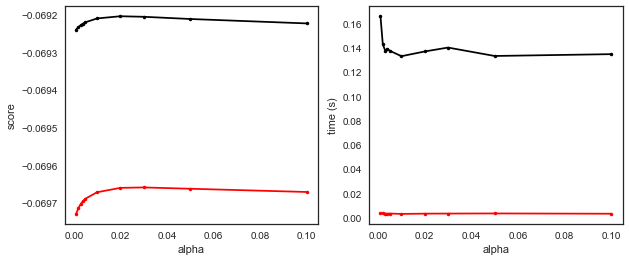

In [140]:
# plot fit results
params={'alpha':[0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.03,0.05,0.1]}
results=linear_reg.cv_results_
plot_cv_results(results,params)
plt.savefig('linear_regression_opt.eps',bbox_inches='tight')

In [12]:
# output results
# prepare the outpu date frame
output=pd.read_csv('sample_submission.csv')
output.set_index('ParcelId',inplace=True)
# predict with linear regression
output_results(output,X_test,linear_reg.best_estimator_,'linear_reg.csv',1)
print("finish linear regression output")

finish output file: linear_reg.csv
finish linear regression output


#### 3.2.3 Decision tree

In [116]:
# optimize decision tree
params={'max_depth':list(range(1,10))}
decision_tree_reg = fit_model(X_train,y_train,DecisionTreeRegressor(random_state=50),params)

[[1, 2, 3, 4, 5, 6, 7, 8, 9]]


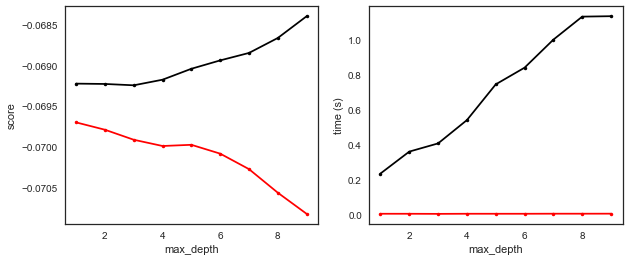

In [141]:
# plot fit results
params={'max_depth':list(range(1,10))}
results=decision_tree_reg.cv_results_
plot_cv_results(results,params)
plt.savefig('decision_tree_opt.eps',bbox_inches='tight')

In [5]:
# output results
# prepare the outpu date frame
output=pd.read_csv('sample_submission.csv')
output.set_index('ParcelId',inplace=True)
# predict decision tree
output_results(output,X_test,decision_tree_reg.best_estimator_,'decision_tree_reg.csv',1)
print("finish decision_tree output")

finish output file: decision_tree_reg.csv
finish decision_tree output


#### 3.2.4 Random forest

In [114]:
# optimize random forest
params={'max_depth':list(range(1,10))}
random_forest_reg= fit_model(X_train,y_train,RandomForestRegressor(random_state=50,n_estimators=50,n_jobs=2),params)

[[1, 2, 3, 4, 5, 6, 7, 8, 9]]


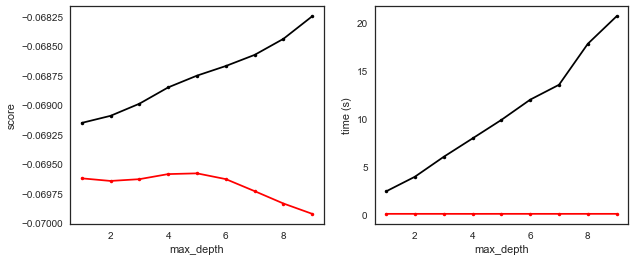

In [142]:
# plot fit results
params={'max_depth':list(range(1,10))}
results=random_forest_reg.cv_results_
plot_cv_results(results,params)
plt.savefig('random_forest_opt.eps',bbox_inches='tight')

In [9]:
# output results
# prepare the outpu date frame
output=pd.read_csv('sample_submission.csv')
output.set_index('ParcelId',inplace=True)
# predict random forest
output_results(output,X_test,random_forest_reg.best_estimator_,'random_forest_reg.csv',1)
print("finish random_forest output")

finish output file: random_forest_reg.csv
finish random_forest output


The importance of different features to predict log error.


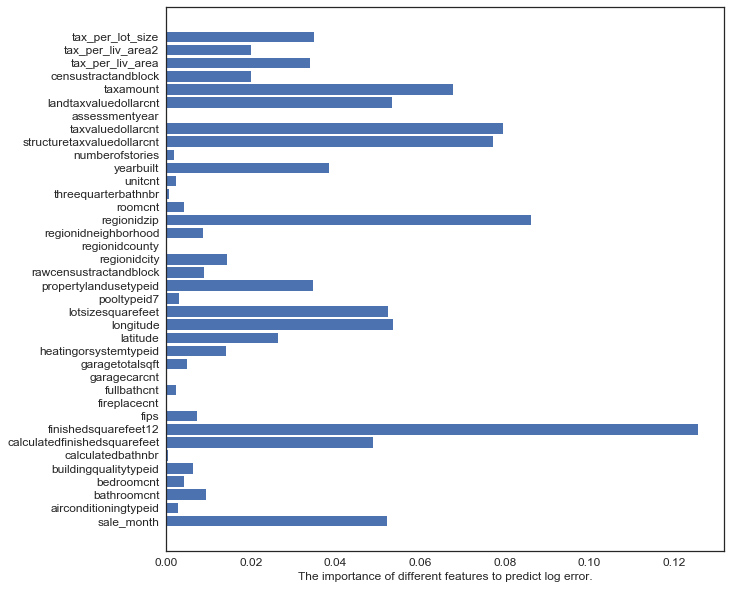

In [188]:
# plot feature importance
feature_importance=random_forest_reg.best_estimator_.feature_importances_

# correlation coefficient with log error of different features
ax=plt.figure(figsize=(10,10))
plt.barh(range(38),feature_importance)
plt.yticks(range(38), X_train.columns.tolist(),fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('The importance of different features to predict log error.',fontsize=12)
#plt.title('Correlation coefficient with log error of different features',fontsize=16)
print('The importance of different features to predict log error.')
plt.savefig('feature_importance.eps',bbox_inches='tight')

**Insight 11. The importance of features suggests that the size of the house, location, tax value, yearbuild and sale month may be the most important set of features to affection prediction error.**

In [155]:
len(X_train.columns.tolist())

38

#### 3.2.5 K-nearest neighbors

In [128]:
# optimize knn
params={'n_neighbors':[4,8,12,16,20]}
knn_reg= fit_model(X_train,y_train,KNeighborsRegressor(n_jobs=2),params)

[[4, 8, 12, 16, 20]]


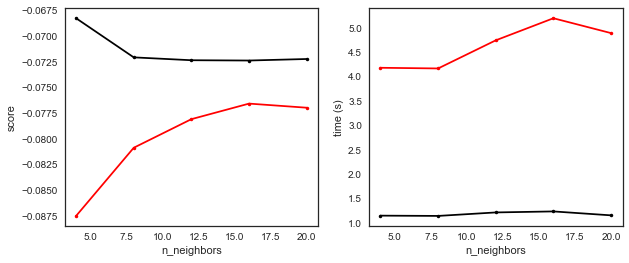

In [143]:
# plot fit results
params={'n_neighbors':[4,8,12,16,20]}
results=knn_reg.cv_results_
plot_cv_results(results,params)
plt.savefig('knn_opt.eps',bbox_inches='tight')

In [21]:
# output results
# prepare the outpu date frame
output=pd.read_csv('sample_submission.csv')
output.set_index('ParcelId',inplace=True)
# predict random forest
output_results(output,X_test,knn_reg.best_estimator_,'knn_reg.csv',1)
print("finish knn output")

In [136]:
## save model
from sklearn.externals import joblib
joblib.dump(linear_reg, 'linear_reg_normal.pkl') 
joblib.dump(decision_tree_reg, 'decision_tree_reg_normal.pkl') 
joblib.dump(knn_reg, 'knn_reg_normal.pkl') 
joblib.dump(random_forest_reg, 'random_forest_normal.pkl') 

['random_forest_normal.pkl']

In [19]:
# load model and fit
#from sklearn.externals import joblib
#linear_reg=joblib.load('linear_reg_normal.pkl') 
#reg_decision_tree=joblib.load('decision_tree_reg_normal.pkl') 
#knn_reg=joblib.load('knn_reg_normal.pkl') 
#ada_reg=joblib.load('ada_reg_normal.pkl') 
#random_forest_reg=joblib.load('random_forest_normal.pkl') 
#linear_reg.fit(X_train,y_train)
#print('finish linear regression')
#reg_decision_tree.best_estimator_.fit(X_train,y_train)
#print('finish decision tree')
#knn_reg.fit(X_train,y_train)
#print('finish knn')
#ada_reg.fit(X_train,y_train)
#print('finish ada boosting')
#random_forest_reg.best_estimator_.fit(X_train,y_train)
#print('finish random forest')

finish linear regression
finish decision tree
finish knn
finish ada boosting
finish random forest


#### 3.2.6 Light-gbm

[[0.008, 0.012, 0.016, 0.02]]


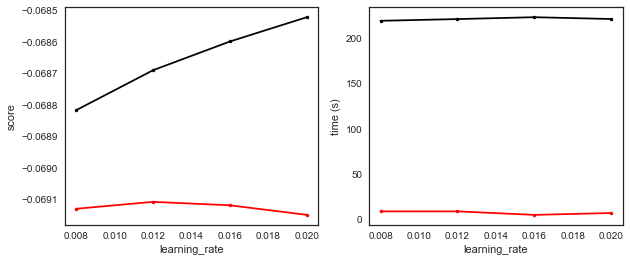

In [164]:
# gridsearchcv results for learning rate of lightgbm
light_gbm_lr_cv_results={'split0_test_score': np.array([-0.07356084, -0.07350209, -0.07348418, -0.07348774]), 
 'split1_test_score': np.array([-0.06740119, -0.06741161, -0.06744009, -0.0674886 ]), 
 'split2_test_score': np.array([-0.0664278 , -0.06641023, -0.06643247, -0.06647165]), 
 'mean_test_score': np.array([-0.06912999, -0.06910803, -0.06911896, -0.06914938]), 
 'std_test_score': np.array([ 0.00315823,  0.0031339 ,  0.00311401,  0.0030957 ]), 
 'rank_test_score': np.array([3, 1, 2, 4], dtype=np.int32), 
 'split0_train_score': np.array([-0.06655967, -0.06644191, -0.06636603, -0.06628521]), 
 'split1_train_score': np.array([-0.06996914, -0.06986604, -0.06979102, -0.06973722]), 
 'split2_train_score': np.array([-0.06992129, -0.06976146, -0.06963857, -0.06954174]), 
 'mean_train_score': np.array([-0.0688167 , -0.0686898 , -0.06859854, -0.06852139]), 
 'std_train_score': np.array([ 0.00159608,  0.00159007,  0.00157985,  0.00158323]), 
 'mean_fit_time': np.array([ 219.51130382,  221.41814049,  223.48714399,  221.4878931 ]), 
 'std_fit_time': np.array([ 17.7584018 ,   9.16827745,   4.71680123,   5.5057297 ]), 
 'mean_score_time': np.array([ 9.0138859 ,  8.99046206,  5.13893859,  7.16927417]), 
 'std_score_time': np.array([ 7.81742198,  5.74577804,  3.37896478,  2.62427975]), 
 'param_learning_rate': np.array([0.008,0.012,0.016,0.02])}
params={'learning_rate':[0.008,0.012,0.016,0.02]}
plot_cv_results(light_gbm_lr_cv_results,params)
plt.savefig('lightgbm_lr_opt.eps',bbox_inches='tight')

### 3.3 Model evaluation
#### 3.3.1 Trained model performance
<br> train score

In [137]:
# calculate performance metric for all five models
y_predict=linear_reg.best_estimator_.predict(X_train)
print('linear regression: ', mean_absolute_error(y_predict,y_train))
y_predict=decision_tree_reg.best_estimator_.predict(X_train)
print('linear regression: ', mean_absolute_error(y_predict,y_train))
y_predict=knn_reg.best_estimator_.predict(X_train)
print('k nearest neighbour: ', mean_absolute_error(y_predict,y_train))
#y_predict=ada_reg.predict(X_train)
#print('ada boosting: ', mean_absolute_error(y_predict,y_train))
y_predict=random_forest_reg.best_estimator_.predict(X_train)
print('random forest: ', mean_absolute_error(y_predict,y_train))

linear regression:  0.0692758589775
decision tree:  0.0693047143577
k nearest neighbour:  0.0720146467388
random forest:  0.0688313016709


In [1]:
# the lightgbm model is run on the kaggle platform.
print('Lightgbm: 0.0686')

Lightgbm: 0.0686


test score

In [2]:
print('linear regression: 0.0655')
print('decision tree: 0.0654')
print('k nearest neighbour: 0.0899')
print('random forest: 0.0653')
print('Lightgbm: 0.0650')

linear regression: 0.0655
decision tree: 0.0654
k nearest neighbour: 0.0899
random forest: 0.0653
Lightgbm: 0.0650


#### 3.3.2 Benchmark model: Predict a constant median value

In [3]:
#np.mean(abs(y_train-y_train.median()))
print('train score:',0.0690)
print('test score:',0.0656)

train score: 0.069
test score: 0.0656


**Insight 12. According to these scores, LightGBM has the best performance out of all different models. The performance of linear regression, decision tree and random forest are only slightly better than the benchmark model, while the $k$-nearest neighbor model performs has the worst performance. The reason may be that the size of the training dataset is not large enough to cover the complete range of then feature space. For outliers, the prediction by $k$-nearest neighbor model is not reliable. In general, the LightGBM model is chosen as the best model to predict $\xi_{\log}$ for this project.**

#### 3.3.3 Model comparison
The monthly averaged $\xi_{\log}$ predicted by different regression models is compared to the training data. The prediction from linear regression, decision tree, random forest and LightGBM are similar. The LightGBM model tends to predict the median value of $\xi_{\log}$ from the training data to achieve less MAE. Compared to the benchmark model which applies the median value of $\xi_{\log}$ of the training dataset as the final prediction, the LightGBM model improves the prediction by decreasing 0.0006 MAE. This is a great improvement if considering the best score in the leaderboard of this Zillow competition on Kaggle platform is 0.0644, only 0.006 smaller than the score achieved by the proposed LightGBM model.

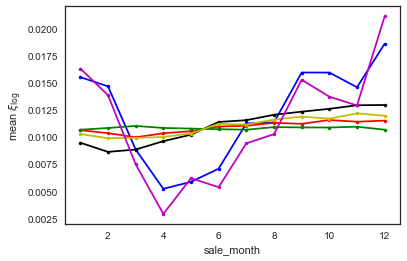

In [187]:
# compare monthly average log error to validate model
train_df=pd.read_csv('lightgbm_train_output.csv')
train_df['sale_month']=train_df['sale_month']*12
plt.plot(train_df[['logerror','sale_month']].groupby('sale_month').mean(),'b.-')
plt.plot(train_df[['logerror_predict','sale_month']].groupby('sale_month').mean(),'r.-')
train_df['logerror_predict']=linear_reg.best_estimator_.predict(X_train)
plt.plot(train_df[['logerror_predict','sale_month']].groupby('sale_month').mean(),'k.-')
train_df['logerror_predict']=decision_tree_reg.best_estimator_.predict(X_train)
plt.plot(train_df[['logerror_predict','sale_month']].groupby('sale_month').mean(),'g.-')
train_df['logerror_predict']=random_forest_reg.best_estimator_.predict(X_train)
plt.plot(train_df[['logerror_predict','sale_month']].groupby('sale_month').mean(),'y.-')
train_df['logerror_predict']=knn_reg.best_estimator_.predict(X_train)
plt.plot(train_df[['logerror_predict','sale_month']].groupby('sale_month').mean(),'m.-')
plt.xlabel('sale_month')
plt.ylabel(r'mean $\xi_{\log}$')
plt.savefig('monthly-average-error-prediction.eps',bbox_inches='tight')

Legend: blue: exact $\xi_{\log}$, red: LightGBM, black: linear regression, green: decision tree, yellow: random forest, magenta: $k$-nearest neighbor
<br>**Insight 13. k-nearest neighbor model reproduces the pattern of training data. The prediction of other models tends to be the modified version of the benchmark model.**

## 4. Conclusion
### 4.1 Project summary
In this project, the Zillow dataset for the Kaggle competition is visualized, analyzed and applied to predict $\xi_{\log}$ between the real sale price and the Zillow 'Zestimate'. A complete exploratory analysis on both the transaction and properties datasets has been conducted to indicate the possible relationship between $\xi_{\log}$ and different features. Meanwhile, a reasonable data preprocessing has been conducted to clean the dataset, while different regression models have been optimized to accurately predict $\xi_{\log}$. Compared to other regression models, since the LightGBM performs best without any compromise in both accuracy and efficiency, it is chosen as the best model to predict $\xi_{\log}$ in this project.
### 4.2 Guidence from feature importance
In order to demonstrate the key factors in predicting $\xi_{\log}$, the importance of different features is shown. According to this Figure, the zip code, property tax, house lot size and yearbuilt are the most important features. This indicates that the original algorithm of 'Zestimate' need to be improved on the representation of these features on predicting house sale price. Starting from this point, different sensitivity tests and parameter tuning can be conducted to increase the reliability of the 'Zestimate' model when the original algorithm of 'Zestimate' is accessible.

### 4.3 Possible improvement
Compared to the best score (lowest MAE) 0.0644 on the leaderboard of this competition, the performance of the LightGBM model can still be improved from many aspects. Here are some possible ways:
<br> 1) Involve more features: Due to the high missing rate, more than 40% features is removed although the cutoff percentage is set as high as 90%. If the information from removed features can be still used, it may improve the performance of the LightGBM model.
<br> 2) Better missing values: Currently, the missing values are filled with the mean, median and most frequent values for different features. This may be not reasonable since some known features may relate to the feature with missing values. A better missing values should be predicted by the know information from each house. For example, if latitude and longitude are known, and the zip code is not known, the missing zip code should be filled with the exact value based on the geographical information, not the most frequent zip code.
<br> 3) Create more features: In this project, three new features are created to improve regression models. According to the feature importance, they are all important to predict $\xi_{\log}$. More reasonable new features can be created to improve model performance. 
<br> 4) Parameter tuning: The LightGBM model has many parameter to choose for best performance. In this project, only the optimization of learning rate is conducted. More cross validation process is required to achieve better parameters from the model.
<br> 5) Boosting with other models: The LightGBM model is a gradient boosting framework using tree based learning algorithm. In order to achieve better performance, the same boosting technique can be applied to combine the results from different regression models.